<a href="https://colab.research.google.com/github/rtajeong/DSAC_Lab3_4/blob/master/deu_lab3_multinomial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multinomial classification
- iris dataset
- one-hot encoding
- softmax
- cross entropy (multi-class)

In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [5]:
iris_data = sns.load_dataset('iris')
iris_data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [17]:
X, y = iris_data.values[:, :4].astype('float32'), iris_data.values[:,4]

In [18]:
Y_pre = LabelEncoder().fit_transform(y)
Y = np_utils.to_categorical(Y_pre)

In [19]:
X[:3], Y[-3:]

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2]], dtype=float32), array([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], dtype=float32))

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [26]:
X_train.shape, Y_train.shape

((120, 4), (120, 3))

In [30]:
model = Sequential()
model.add(Dense(16, input_shape=(4,), activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
history = model.fit(X_train, Y_train, epochs=200, batch_size=10,
                    verbose=0)
model.save('iris_model.h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 51        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [28]:
del model
model = load_model('iris_model.h5')
model.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 1ms/step - loss: 0.1971 - accuracy: 1.0000


[0.19709405303001404, 1.0]

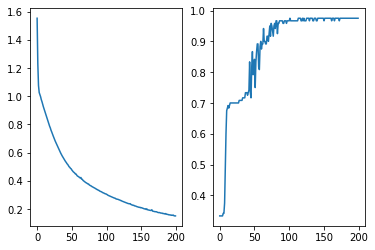

In [29]:
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])

# K-Fold Validation

In [51]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True,random_state=17)
cv_scores = []

for train_index, test_index in skf.split(X, Y_pre):
    model = Sequential()
    model.add(Dense(16, input_shape=(4,), activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y_pre[train_index], Y_pre[test_index]
    Y_train_ohe = np_utils.to_categorical(Y_train)
    Y_test_ohe = np_utils.to_categorical(Y_test)

    model.fit(X_train, Y_train_ohe, epochs=50, batch_size=10, verbose=0)
    score = model.evaluate(X_test, Y_test_ohe)
    cv_scores.append(score)

cv_scores

1/1 [==============================] - 0s 4ms/step - loss: 0.4370 - accuracy: 0.8667


[[0.30893269181251526, 1.0],
 [0.3313716650009155, 1.0],
 [0.3699333965778351, 0.9333333373069763],
 [0.4561339318752289, 0.800000011920929],
 [0.4386020600795746, 0.9333333373069763],
 [0.27075088024139404, 1.0],
 [0.4017382264137268, 0.8666666746139526],
 [0.40283477306365967, 1.0],
 [0.22110465168952942, 1.0],
 [0.4370015561580658, 0.8666666746139526]]

# Callback - checkpoint and early stopping

In [53]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import pandas as pd

In [63]:
df = pd.read_csv('wine.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [64]:
df_all.shape

(6497, 13)

In [65]:
df_all[12].value_counts()

0    4898
1    1599
Name: 12, dtype: int64

In [66]:
df_all.describe().T

,count,mean,std,min,25%,50%,75%,max
0,6497.0,7.215307,1.296434,3.80000,6.40000,7.00000,7.70000,15.90000
1,6497.0,0.339666,0.164636,0.08000,0.23000,0.29000,0.40000,1.58000
2,6497.0,0.318633,0.145318,0.00000,0.25000,0.31000,0.39000,1.66000
3,6497.0,5.443235,4.757804,0.60000,1.80000,3.00000,8.10000,65.80000
4,6497.0,0.056034,0.035034,0.00900,0.03800,0.04700,0.06500,0.61100
5,6497.0,30.525319,17.749400,1.00000,17.00000,29.00000,41.00000,289.00000
6,6497.0,115.744574,56.521855,6.00000,77.00000,118.00000,156.00000,440.00000
7,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898
8,6497.0,3.218501,0.160787,2.72000,3.11000,3.21000,3.32000,4.01000
9,6497.0,0.531268,0.148806,0.22000,0.43000,0.51000,0.60000,2.00000


In [67]:
df.values

array([[ 7.4 ,  0.7 ,  0.  , ...,  9.4 ,  5.  ,  1.  ],
       [ 7.8 ,  0.88,  0.  , ...,  9.8 ,  5.  ,  1.  ],
       [ 7.8 ,  0.76,  0.04, ...,  9.8 ,  5.  ,  1.  ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  9.4 ,  6.  ,  0.  ],
       [ 5.5 ,  0.29,  0.3 , ..., 12.8 ,  7.  ,  0.  ],
       [ 6.  ,  0.21,  0.38, ..., 11.8 ,  6.  ,  0.  ]])

In [88]:
X, y = df.values[:, :12], df.values[:, 12]

In [89]:
model = Sequential()
model.add(Dense(30, input_shape=(12,), activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# create directory to store model information
MODEL_DIR = './model/'
if not os.path.exists (MODEL_DIR):
    os.mkdir(MODEL_DIR)

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 30)                390       
_________________________________________________________________
dense_65 (Dense)             (None, 12)                372       
_________________________________________________________________
dense_66 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 9         
Total params: 875
Trainable params: 875
Non-trainable params: 0
_________________________________________________________________


In [90]:
modelpath = "./model/{epoch:02d}-{val_loss:.4f}.hdf5"

checkpoiner = ModelCheckpoint(filepath=modelpath,
                              monitor='val_loss',
                              verbose=1,
                              save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=100)

In [91]:

history = model.fit(X, y, validation_split=0.2,
                    epochs=2000, batch_size=100, verbose=0,
                    callbacks = [early_stopping_callback, checkpoiner])


Epoch 00001: val_loss improved from inf to 0.22386, saving model to ./model/01-0.2239.hdf5

Epoch 00002: val_loss improved from 0.22386 to 0.18433, saving model to ./model/02-0.1843.hdf5

Epoch 00003: val_loss improved from 0.18433 to 0.13247, saving model to ./model/03-0.1325.hdf5

Epoch 00004: val_loss did not improve from 0.13247

Epoch 00005: val_loss did not improve from 0.13247

Epoch 00006: val_loss improved from 0.13247 to 0.12818, saving model to ./model/06-0.1282.hdf5

Epoch 00007: val_loss did not improve from 0.12818

Epoch 00008: val_loss did not improve from 0.12818

Epoch 00009: val_loss did not improve from 0.12818

Epoch 00010: val_loss did not improve from 0.12818

Epoch 00011: val_loss improved from 0.12818 to 0.12580, saving model to ./model/11-0.1258.hdf5

Epoch 00012: val_loss improved from 0.12580 to 0.11677, saving model to ./model/12-0.1168.hdf5

Epoch 00013: val_loss improved from 0.11677 to 0.08576, saving model to ./model/13-0.0858.hdf5

Epoch 00014: val_lo

In [92]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

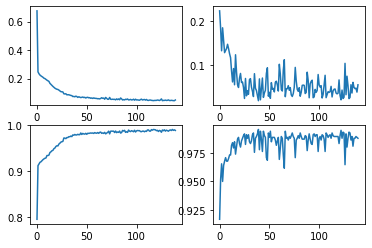

In [93]:
y_loss, y_vloss = history.history['loss'], history.history['val_loss']
y_acc, y_vacc = history.history['accuracy'], history.history['val_accuracy']

plt.subplot(2,2,1)
plt.plot(y_loss)
plt.subplot(2,2,2)
plt.plot(y_vloss)
plt.subplot(2,2,3)
plt.plot(y_acc)
plt.subplot(2,2,4)
plt.plot(y_vacc)